In [1]:
import pandas as pd
import faiss
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import io
import os

from openai import OpenAI

import base64
import requests

import json
import re

from peft import get_peft_model, LoraConfig, TaskType
from safetensors import safe_open
from pllava import PllavaProcessor, PllavaForConditionalGeneration, PllavaConfig
from accelerate import dispatch_model, infer_auto_device_map
from accelerate.utils import get_balanced_memory

In [2]:
torch.cuda.set_device(0)

In [3]:

def show_image(image_paths, sentence=None):
    k=(len(image_paths)+4)//5
    fig, axs = plt.subplots(nrows=k, ncols=5, figsize=(20, 8))  
    axs = axs.flatten()  

    
    for ax, img_path in zip(axs, image_paths):
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')  
            ax.set_title(img_path.split('/')[-1])  
        except FileNotFoundError:
            ax.imshow(np.zeros((10, 10, 3), dtype=int))  
            ax.axis('off')
            ax.set_title('File Not Found')
    if sentence:
        fig.suptitle(sentence, fontsize=16)
    plt.tight_layout()
    plt.show()

def load_image(image_file):
    if image_file.startswith("http") or image_file.startswith("https"):
        response = requests.get(image_file)
        image = Image.open(io.BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image

def chosen_reject(query, question, target_image_path):

    
    image_paths, indices = retrieve_topk_images([query],
                                                topk=50000,
                                                faiss_model=faiss_model,
                                                blip_model=dialog_encoder,
                                                id2image=id2image,
                                                processor=None)
    image_rank = find_index_in_list(target_image_path, image_paths[0])

    
    base64_target_image = encode_image(target_image_path)
    answer_of_question = answer(question, base64_target_image)

    
    summary_of_question_and_option = summary(query, question, answer_of_question)

    
    image_paths_new, indices_new = retrieve_topk_images([summary_of_question_and_option],
                                                        topk=50000,
                                                        faiss_model=faiss_model,
                                                        blip_model=dialog_encoder,
                                                        id2image=id2image,
                                                        processor=None)
    image_rank_new = find_index_in_list(target_image_path, image_paths_new[0])

    flag = image_rank - image_rank_new
    if flag >= 0:
        return 1
    else:
        return 0



class ImageEmbedder:
    def __init__(self, model, preprocessor):
        """ model projects image to vector, processor load and prepare image to the model"""
        self.model = model
        self.processor = preprocessor

def BLIP_BASELINE():
    from torchvision import transforms
    from torchvision.transforms.functional import InterpolationMode

    import sys
    sys.path.insert(0, './BLIP')
    from BLIP.models.blip_itm import blip_itm
    # load model
    model = blip_itm(pretrained='./BLIP/chatir_weights.ckpt',  # Download from Google Drive, see README.md
                     med_config='BLIP/configs/med_config.json',
                     image_size=224,
                     vit='base'
                     )

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device).eval()

    # define Image Embedder (raw_image --> img_feature)
    transform_test = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])

    def blip_project_img(image):
        embeds = model.visual_encoder(image)
        projection = model.vision_proj(embeds[:, 0, :])
        return F.normalize(projection, dim=-1)

    def blip_prep_image(path):
        raw = Image.open(path).convert('RGB')
        return transform_test(raw)

    image_embedder = ImageEmbedder(blip_project_img, lambda path: blip_prep_image(path))

    # define dialog encoder (dialog --> img_feature)
    def dialog_encoder(dialog):
        text = model.tokenizer(dialog, padding='longest', truncation=True,
                               max_length=200,
                               return_tensors="pt"
                               ).to(device)

        text_output = model.text_encoder(text.input_ids, attention_mask=text.attention_mask,
                                         return_dict=True, mode='text')

        shift = model.text_proj(text_output.last_hidden_state[:, 0, :])
        return F.normalize(shift, dim=-1)

    return dialog_encoder, image_embedder

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts: list):
        """
        Args:
            texts (list of str): List of text strings.
            processor (transformers processor): Processor to tokenize the text.
        """
        self.texts = texts
        # self.processor = processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]  # Get the text at the provided index
        return {'text': text}

def encode_text(dataset, model):
    """CLIP for encode text """
    # model.eval()
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=70,
                                              pin_memory=True,
                                              num_workers=2,
                                              prefetch_factor=2,
                                              shuffle=False,
                                              
                                              )
    all_features = []
    with torch.no_grad():
        for batch in data_loader:
            features = model(batch['text'])
            all_features.append(features.cpu())  
    return torch.cat(all_features)  

def retrieve_topk_images(query: list,
                         topk=10,
                         faiss_model=None,
                         blip_model=None,
                         id2image=None,
                         processor=None, ):
    text_dataset = TextDataset(query)
    query_vec = encode_text(text_dataset, blip_model)
    query_vec = query_vec.numpy()
    query_vec /= np.linalg.norm(query_vec, axis=1, keepdims=True)

    distance, indices = faiss_model.search(query_vec, topk)
    indices = np.array(indices)
    image_paths = [[id2image.get(idx, 'path/not/found') for idx in row] for row in indices]
    return image_paths, indices



def find_index_in_list(element, my_list):
    return my_list.index(element) 


def load_pllava(repo_id, num_frames, use_lora=False, weight_dir=None, lora_alpha=32, use_multi_gpus=False, pooling_shape=(16,12,12)):
    kwargs = {
        'num_frames': num_frames,
    }
    # print("===============>pooling_shape", pooling_shape)
    if num_frames == 0:
        kwargs.update(pooling_shape=(0,12,12)) # produce a bug if ever usen the pooling projector
    config = PllavaConfig.from_pretrained(
        repo_id if not use_lora else weight_dir,
        pooling_shape=pooling_shape,
        **kwargs,
    )


    with torch.no_grad():
        model = PllavaForConditionalGeneration.from_pretrained(repo_id, config=config, torch_dtype=torch.bfloat16)

    try:
        processor = PllavaProcessor.from_pretrained(repo_id)
    except Exception as e:
        processor = PllavaProcessor.from_pretrained('llava-hf/llava-1.5-7b-hf')

    # config lora
    if use_lora and weight_dir is not None:
        print("Use lora")
        peft_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM, inference_mode=False,  target_modules=["q_proj", "v_proj"],
            r=128, lora_alpha=lora_alpha, lora_dropout=0.
        )
        print("Lora Scaling:", lora_alpha/128)
        model.language_model = get_peft_model(model.language_model, peft_config)
        assert weight_dir is not None, "pass a folder to your lora weight"
        print("Finish use lora")

    # load weights
    if weight_dir is not None:
        state_dict = {}
        save_fnames = os.listdir(weight_dir)
        if "model.safetensors" in save_fnames:
            use_full = False
            for fn in save_fnames:
                if fn.startswith('model-0'):
                    use_full=True
                    break
        else:
            use_full= True

        if not use_full:
            print("Loading weight from", weight_dir, "model.safetensors")
            with safe_open(f"{weight_dir}/model.safetensors", framework="pt", device="cpu") as f:
                for k in f.keys():
                    state_dict[k] = f.get_tensor(k)
        else:
            print("Loading weight from", weight_dir)
            for fn in save_fnames:
                if fn.startswith('model-0'):
                    with safe_open(f"{weight_dir}/{fn}", framework="pt", device="cpu") as f:
                        for k in f.keys():
                            state_dict[k] = f.get_tensor(k)

        if 'model' in state_dict.keys():
            msg = model.load_state_dict(state_dict['model'], strict=False)
        else:
            msg = model.load_state_dict(state_dict, strict=False)
        print(msg)
    # dispatch model weight
    if use_multi_gpus:
        max_memory = get_balanced_memory(
            model,
            max_memory=None,
            no_split_module_classes=["LlamaDecoderLayer"],
            dtype='bfloat16',
            low_zero=False,
        )

        device_map = infer_auto_device_map(
            model,
            max_memory=max_memory,
            no_split_module_classes=["LlamaDecoderLayer"],
            dtype='bfloat16'
        )

        dispatch_model(model, device_map=device_map)
        print(model.hf_device_map)

    model = model.eval()

    return model, processor


# Convert numpy data types to native Python types for JSON serialization
def convert_type(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj


In [4]:

def question_simple(base64_image_list,query):
    client = OpenAI(api_key='')
    response = client.chat.completions.create(
      model="gpt-4o",
      messages=[
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": f"""
              
            Your task is to identify the target image based on descriptions provided by users. Due to the ambiguity in user descriptions, you have already searched and found 5 images based on these descriptions. Your task is to analyze the content of these 5 images, ask a question to clarify the user's needs, and your question is not overlapping with the descriptions. Thereby helping the user quickly find the target image. You only need to output one questions within 30 words.
            Complete the following tasks step by step:
            1. Combine the textual description:, observe these 5 images, and analyze and summarize their common points and differences.
            2. To find the target image, ask a question based on these differences that can clarify the user’s needs and help them quickly find the target image.
            [Your Question]
            Based on the images and sentence description <{query}>, your questions are:
              """,
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image_list[0]}",
              },
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image_list[1]}",
              },
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image_list[2]}",
              },
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image_list[3]}",
              },
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image_list[4]}",
              },
            },
          ],
        }
      ],
      max_tokens=500,
    )
    return response.choices[0].message.content


In [5]:

def question_attribute(base64_image_list, query):
    client = OpenAI(api_key='')
    response = client.chat.completions.create(
      model="gpt-4o",
      messages=[
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": f"""
                You need to find a common object that appears in all 5 pictures but has distinguishing features. Based on this object, ask a question to differentiate the pictures.

                Remember, you must ensure the question is specific, not abstract, and the answer should be directly obtainable by looking at the images.
                
                For example:
                Example 1: All 5 pictures have people, but the number of people differs. You can ask about the number of people.
                Example 2: All 5 pictures have cats, but the colors are different. You can ask about the color.
                Example 3: All 5 pictures have traffic lights, but their positions differ. You can ask about the position of the traffic lights.
                
                Ask a specific question based on the object that will help distinguish the pictures. The question is not overlapped with the description: {query}.
                Don't ask 2 questions each time. such as what is the attribute of a or b

                Output as the following format
                {{
                "What is the common object that appears in all five pictures":"",
                "What is he distinguishing feature that can help differentiate the picture":"",
                "Question to differentiate the pictures":""
                }}
                ""
                
              """,
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image_list[0]}",
              },
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image_list[1]}",
              },
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image_list[2]}",
              },
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image_list[3]}",
              },
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image_list[4]}",
              },
            },
          ],
        }
      ],
      max_tokens=500,
    )
    return response.choices[0].message.content



def extract_json(text):
    pattern = r'{.*}'
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group()
    else:
        return 'parse incorrectly'

In [6]:
def question_attribute_llava(images_path, query, model=None,
                     processor=None):
    prompt = f"""You are Pllava, a large vision-language assistant.
    You are able to understand the video content that the user provides, and assist the user with a variety of tasks using natural language.
    Follow the instructions carefully and explain your answers in detail based on the provided video.
     USER:<image>  USER: our task is to identify the target image based on descriptions provided by users. Due to the ambiguity in user descriptions, you have already searched and found 5 images based on these descriptions. Your task is to analyze the content of these 5 images, ask a question to clarify the user's needs, and your question is not overlapping with the descriptions. Thereby helping the user quickly find the target image. You only need to output one questions within 30 words.
                Complete the following tasks step by step:
                1. Combine the textual description, observe these 5 images, and analyze and summarize their common points and differences.
                2. To find the target image, ask a question based on these differences that can clarify the user’s needs and help them quickly find the target image.
                [Your Question]
                Based on the images and sentence description, {query}. one question you asked is:
     ASSISTANT:"""
    image_tensor = [load_image(img_file) for img_file in images_path]
    inputs = processor(prompt, image_tensor, return_tensors="pt")
    inputs = {k:v.to("cuda") for k,v in inputs.items()}
    with torch.no_grad():
        output_token = model.generate(**inputs, media_type='video',
                                    do_sample=False,
                                    max_new_tokens=500,
                                      num_beams=1,
                                      min_length=1,
                                    top_p=0.9,
                                      repetition_penalty=1,
                                      length_penalty=1,
                                      temperature=1,
                                    ) # dont need to long for the choice.
    torch.cuda.empty_cache() # clear the history for this batch
    output_text = processor.batch_decode(output_token, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    # extract the question
    output_text = output_text.split('ASSISTANT:')[-1].strip()
    return output_text

In [7]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [8]:

def answer(question,base64_target_image):
    client = OpenAI(api_key='')
    response = client.chat.completions.create(
      model="gpt-4o",
      messages=[
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": f"according to the image, answer the question:{question}，Your answer must be direct and simple",
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_target_image}",
              },
            }
          ],
        }
      ],
      max_tokens=100,
    )
    return response.choices[0].message.content

In [9]:

def summary(query,question,answer):
    client = OpenAI(api_key='')
    response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": f"""
        Your task is to summarize the information from the image's question and answer and add this information to the original image description.\
        Remember: the summarized information must be concise, and the original description should not be altered.

        <question>
        {question}
        <answer>
        {answer}
        <image description>
        {query}


The information extracted from the question and answer should be added to the original description as an attribute or a simple attributive clause.
        """
        },
        {"role": "user", "content": ""}
      ]
    )
    return response.choices[0].message.content

In [10]:
faiss_model = faiss.read_index('./checkpoints/blip_faiss.index')
with open('./checkpoints/id2image.pickle', 'rb') as f:
    id2image = pickle.load(f)
    
with open('./checkpoints/blip_image_embedding.pickle', 'rb') as f:
    image_vector = pickle.load(f)
dialog_encoder, image_embedder = BLIP_BASELINE()

load checkpoint from ./BLIP/chatir_weights.ckpt


In [27]:
recall_res = pd.read_csv('recall_res.csv')

In [28]:
# non-top10 dataset

recall_res = pd.DataFrame()
for p in os.listdir('./top_interval_res'):
    if '0-9' not in p:
        tmp = pd.read_csv('./top_interval_res/' + p)
        recall_res = pd.concat([recall_res,tmp], axis=0)
recall_res = recall_res[['option', 'recall_images', 'target_image']]
recall_res = recall_res.reset_index()

In [29]:
len(recall_res)

755

In [30]:
# recall_res

./playground/data/css_data/unlabeled2017/000000296319.jpg


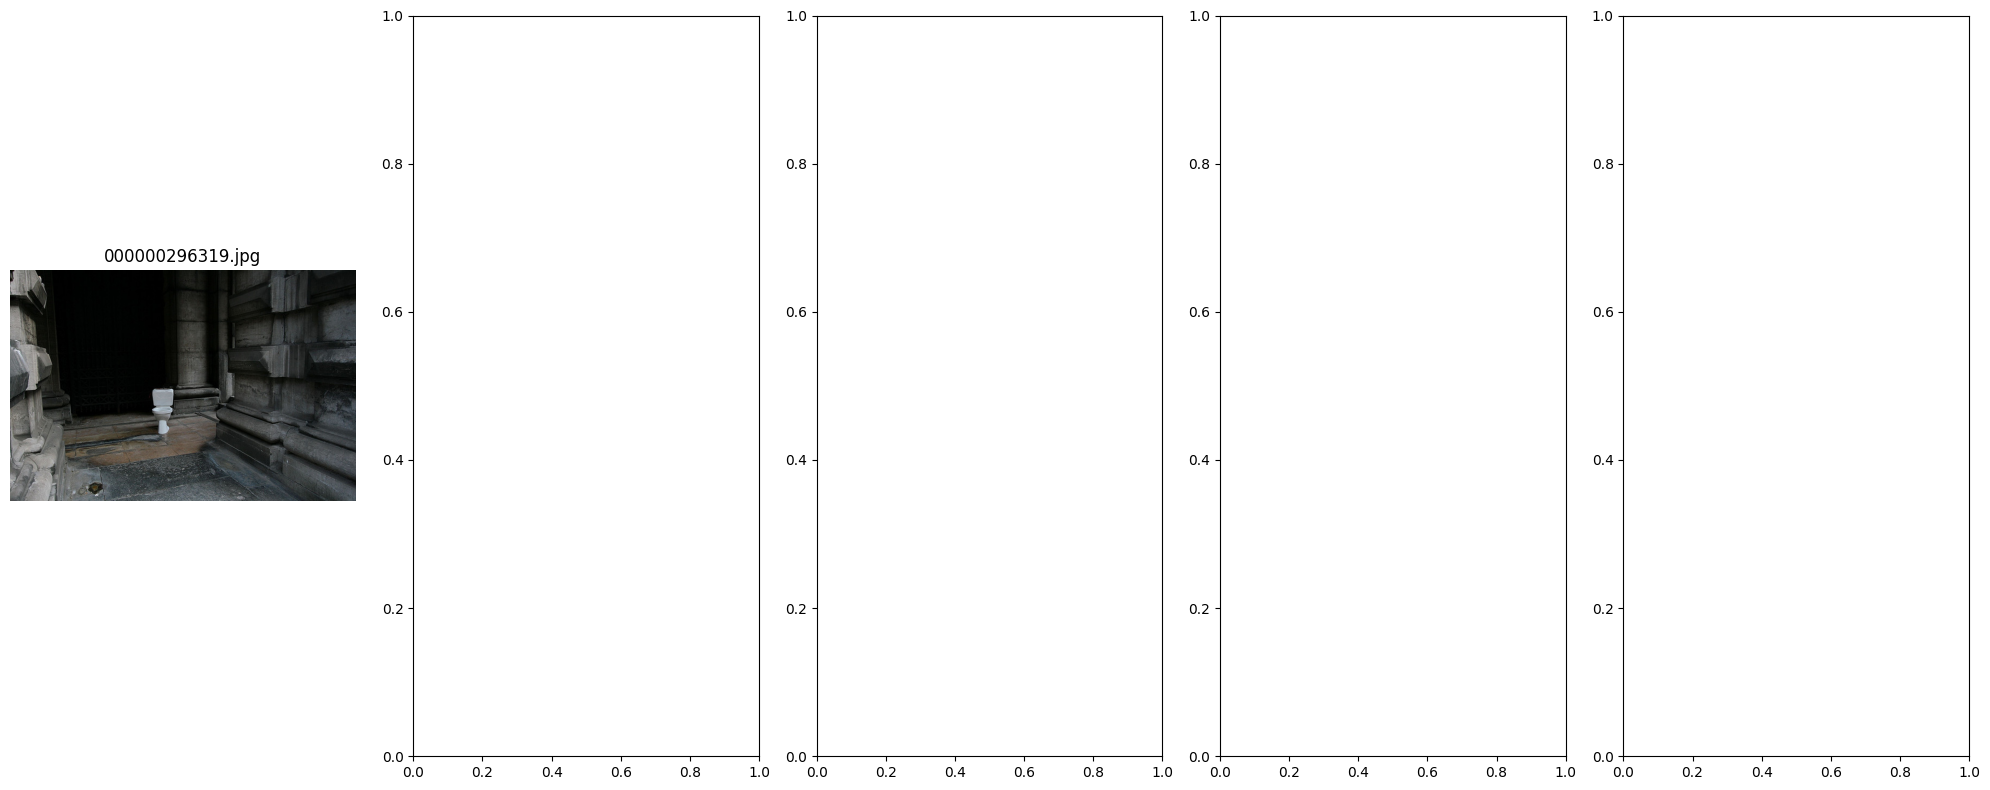

NameError: name 'llava_model' is not defined

In [31]:
i=0
question_model_type = 'llava'
query=recall_res["option"][i]
target_image_path='./playground/data/css_data/'+recall_res["target_image"][i]
print(target_image_path)
show_image([target_image_path], sentence=None)
image_paths,indices=retrieve_topk_images([query],
                         topk=100,
                         faiss_model=faiss_model,
                         blip_model=dialog_encoder,
                         id2image=id2image,
                         processor=None, )
image_rank=find_index_in_list(target_image_path , image_paths[0])
top_images_path=image_paths[0][:40]
random_selection_path = random.sample(top_images_path, 5)
if question_model_type =='gpt4':
    base64_image_top=[]
    for image_path in random_selection_path:
        base64_image_top.append(encode_image(image_path))
    question_fewshot=question_attribute(base64_image_top,query)
    question_fewshot_json=json.loads(extract_json(question_fewshot))
    question=question_fewshot_json["Question to differentiate the pictures"]
elif question_model_type=='llava':
    question = question_attribute_llava(images_path=random_selection_path,
                             query=query,
                             model=llava_model,
                             processor=llava_processor)

base64_target_image=encode_image(target_image_path)
answer_of_question=answer(question,base64_target_image)
summary_of_question_and_option=summary(query,question,answer_of_question)

In [ ]:
image_paths_new,indices=retrieve_topk_images([summary_of_question_and_option],
                         topk=100,
                         faiss_model=faiss_model,
                         blip_model=dialog_encoder,
                         id2image=id2image,
                         processor=None, )
image_rank_new=find_index_in_list(target_image_path , image_paths_new[0])

In [ ]:
image_rank_new

In [ ]:
print("old_rank:",image_rank)
print("new_rank:",image_rank_new)

In [37]:
from tqdm import tqdm

# Hyper Parameters
question_model_type='llava'

query_question=[]
rank_storage=[]
rank_change=[]

print("="*130)

for i in tqdm(range(len(recall_res))):
    query=recall_res["option"][i]
    target_image_path='./playground/data/css_data/'+recall_res["target_image"][i]
    
    
    image_paths, indices=retrieve_topk_images([query],
                             topk=50000,
                             faiss_model=faiss_model,
                             blip_model=dialog_encoder,
                             id2image=id2image,
                             processor=None, )
    image_rank=find_index_in_list(target_image_path , image_paths[0])
    top_images_path=image_paths[0][:40]
    random_selection_path = random.sample(top_images_path, 5)
    
    
    if question_model_type == 'gpt4':
        base64_image_top=[]
        for image_path in random_selection_path:
            base64_image_top.append(encode_image(image_path))
        question_fewshot=question_attribute(base64_image_top,query)

        question_fewshot_json=json.loads(extract_json(question_fewshot))
        question=question_fewshot_json["Question to differentiate the pictures"]
    
    elif question_model_type=='llava':
        question = question_attribute_llava(images_path=random_selection_path,
                             query=query,
                             model=llava_model,
                             processor=llava_processor)
    query_question.append([query, question])
    
    print('-------', query)
    print('random_selection_path', random_selection_path)
    base64_target_image=encode_image(target_image_path)
    answer_of_question=answer(question,base64_target_image)
    
    
    summary_of_question_and_option=summary(query,question,answer_of_question)
    
    
    image_paths_new,indices=retrieve_topk_images([summary_of_question_and_option],
                             topk=50000,
                             faiss_model=faiss_model,
                             blip_model=dialog_encoder,
                             id2image=id2image,
                             processor=None, )
    image_rank_new=find_index_in_list(target_image_path , image_paths_new[0])
    rank_storage.append([image_rank,image_rank_new,image_rank-image_rank_new])
    rank_change.append(image_rank-image_rank_new)
    
    print("old_rank:",image_rank)
    print("new_rank:",image_rank_new)

    print("-"*130)

    save_dict = {'question': question, 'query': query,
     'rank_old': image_rank, 'rank_new': image_rank_new,
     'target_image_path': target_image_path,
     'rank_change': image_rank-image_rank_new}

    with open('./rank_res/non_top10_res.jsonl','a') as f:
        json.dump(save_dict, f)


In [13]:
# non-top10 dataset

recall_res_raw = pd.DataFrame()
for p in os.listdir('./top_interval_res'):
    if '0-9' not in p:
        tmp = pd.read_csv('./top_interval_res/' + p)
        recall_res_raw = pd.concat([recall_res_raw, tmp], axis=0)
recall_res_raw = recall_res_raw[['option', 'recall_images', 'target_image', 'target_image_position']]
recall_res_raw = recall_res_raw.reset_index()

In [14]:
recall_res_raw

,index,option,recall_images,target_image,target_image_position
0,0,a toilet sitting in the middle of an abandoned...,"['unlabeled2017/000000581274.jpg', 'unlabeled2...",unlabeled2017/000000296319.jpg,17
1,1,trailer tractor truck in parking lot with natu...,"['unlabeled2017/000000257200.jpg', 'unlabeled2...",unlabeled2017/000000067272.jpg,10
2,2,a group of skiers waiting for the lift,"['unlabeled2017/000000076320.jpg', 'unlabeled2...",unlabeled2017/000000023817.jpg,16
3,3,a group of giraffes is standing in a savannah,"['unlabeled2017/000000413904.jpg', 'unlabeled2...",unlabeled2017/000000244832.jpg,12
4,4,a bench sits next to a stone path and some plants,"['unlabeled2017/000000072431.jpg', 'unlabeled2...",unlabeled2017/000000052542.jpg,18
...,...,...,...,...,...
750,126,a train parked at the station on a cloudy day,"['unlabeled2017/000000154433.jpg', 'unlabeled2...",unlabeled2017/000000139288.jpg,85
751,127,a speedboat in the middle of a lake headed tow...,"['unlabeled2017/000000133192.jpg', 'unlabeled2...",unlabeled2017/000000217342.jpg,55
752,128,the plate of food has broccoli and other veget...,"['unlabeled2017/000000382679.jpg', 'unlabeled2...",unlabeled2017/000000431962.jpg,71
753,129,the black and white photo shows a woman with a...,"['unlabeled2017/000000272371.jpg', 'unlabeled2...",unlabeled2017/000000542119.jpg,68


In [15]:
def load_jsonl(filename):
    with open(filename, "r") as f:
        return [json.loads(l.strip("\n")) for l in f.readlines()]

interval_prompt_with_option_13b = load_jsonl('./experiment_res/interval_prompt_without_option_newprompt_13b.jsonl')
# interval_prompt_with_option_13b = load_jsonl('./experiment_res/interval_prompt_with_option_13b.jsonl')
interval_prompt_with_option_13b = pd.DataFrame(interval_prompt_with_option_13b)
interval_prompt_with_option_13b = interval_prompt_with_option_13b[['option', 'one_tune_questions']]
interval_prompt_with_option_13b

,option,one_tune_questions
0,a woman playing tennis with the ball in mid-ai...,What is the color of the tennis ball in the im...
1,a nokia tablet pc in a keyboard dock,What is the color of the tablet in the keyboar...
2,a man puts his hand in the water as his body l...,What is the color of the surfboard in the pict...
3,a kitchen is locked behind clear glass doors,What material are the glass doors made of?
4,"vintage black steam train, number 9681, stoppe...",What is the number of the steam train in the p...
...,...,...
750,a train parked at the station on a cloudy day,What is the color of the train in the picture?
751,a speedboat in the middle of a lake headed tow...,What is the color of the boat in the image?
752,the plate of food has broccoli and other veget...,What is the color of the plate in the picture?
753,the black and white photo shows a woman with a...,What is the color of the umbrella in the black...


In [16]:
recall_res = pd.merge(recall_res_raw, interval_prompt_with_option_13b, how='left', on='option')
recall_res

,index,option,recall_images,target_image,target_image_position,one_tune_questions
0,0,a toilet sitting in the middle of an abandoned...,"['unlabeled2017/000000581274.jpg', 'unlabeled2...",unlabeled2017/000000296319.jpg,17,What is the color of the toilet in the image?
1,1,trailer tractor truck in parking lot with natu...,"['unlabeled2017/000000257200.jpg', 'unlabeled2...",unlabeled2017/000000067272.jpg,10,What is the color of the trailer tractor truck...
2,2,a group of skiers waiting for the lift,"['unlabeled2017/000000076320.jpg', 'unlabeled2...",unlabeled2017/000000023817.jpg,16,How many people are in the group of skiers wai...
3,3,a group of giraffes is standing in a savannah,"['unlabeled2017/000000413904.jpg', 'unlabeled2...",unlabeled2017/000000244832.jpg,12,How many giraffes are visible in each picture?
4,4,a bench sits next to a stone path and some plants,"['unlabeled2017/000000072431.jpg', 'unlabeled2...",unlabeled2017/000000052542.jpg,18,What is the material of the bench in the picture?
...,...,...,...,...,...,...
750,126,a train parked at the station on a cloudy day,"['unlabeled2017/000000154433.jpg', 'unlabeled2...",unlabeled2017/000000139288.jpg,85,What is the color of the train in the picture?
751,127,a speedboat in the middle of a lake headed tow...,"['unlabeled2017/000000133192.jpg', 'unlabeled2...",unlabeled2017/000000217342.jpg,55,What is the color of the boat in the image?
752,128,the plate of food has broccoli and other veget...,"['unlabeled2017/000000382679.jpg', 'unlabeled2...",unlabeled2017/000000431962.jpg,71,What is the color of the plate in the picture?
753,129,the black and white photo shows a woman with a...,"['unlabeled2017/000000272371.jpg', 'unlabeled2...",unlabeled2017/000000542119.jpg,68,What is the color of the umbrella in the black...


In [19]:
from tqdm import tqdm

query_question=[]
rank_storage=[]
rank_change=[]

print("="*130)

start_iteration = 168  # this is the last completed iteration
total_iterations = len(recall_res)
for i in tqdm(range(start_iteration, total_iterations), initial=start_iteration, total=total_iterations):
    try:
        query=recall_res["option"][i]
        target_image_path='./playground/data/css_data/'+recall_res["target_image"][i]
        question = recall_res['one_tune_questions'][i]
        image_rank = recall_res['target_image_position'][i]
        

        query_question.append([query, question])

        base64_target_image=encode_image(target_image_path)
        answer_of_question=answer(question,base64_target_image)

        
        summary_of_question_and_option=summary(query, question, answer_of_question)

        
        image_paths_new,indices=retrieve_topk_images([summary_of_question_and_option],
                                 topk=50000,
                                 faiss_model=faiss_model,
                                 blip_model=dialog_encoder,
                                 id2image=id2image,
                                 processor=None, )
        image_rank_new=find_index_in_list(target_image_path , image_paths_new[0])
        rank_storage.append([image_rank,image_rank_new,image_rank-image_rank_new])
        rank_change.append(image_rank-image_rank_new)

        save_dict = {'question': question, 'query': query,
         'rank_old': image_rank, 'rank_new': image_rank_new,
         'target_image_path': target_image_path,
                     'answer_of_question':answer_of_question,
                     'summary_of_question_and_option':summary_of_question_and_option,
         'rank_change': image_rank-image_rank_new}

        with open('./rank_res/non_top10_res_newprompt.jsonl','a') as f:
            json_str = json.dumps(save_dict, default=convert_type)
            f.write(json_str + '\n')
    except:
        pass

100%|██████████| 755/755 [46:18<00:00,  4.73s/it]  


# Generate Choice and rejected data